# Seasonal correlation of CO<sub>2</sub> intensity across NERC regions

## Question being asked

**Is low-CO<sub>2</sub> power being generated at the same time of year across all regions?**

If the seasonal trends are perfectly correlated between regions then it will be much harder to lower emissions in the times of year where all regions have the highest emission intensity. This will place an upper limit on CO<sub>2</sub> intensity of power generation (until we implement seasonal energy storage or new generation technologies).

If all regions produce their lowest intensity power at different times of the year, there may be a greater opportunity to export low-carbon power from one region to another. This isn't an assessment of additional feasible generation, or of exactly what power could be displaced (either in the region of generation or another region). It's just looking at what might be possible if the trends and technologies that are reducing CO<sub>2</sub> emissions in each region continue to grow, and extra low-carbon power in one region became available for consumption in another region.

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import glob
import numpy as np
from statsmodels.tsa.tsatools import detrend

In [13]:
def make_gen_index(data_folder, time='Monthly'):
    """
    Read and combine the state-level generation and index files
    
    inputs:
        data_folder: (str or path) path to the state-level data files
        time: (str) "Monthly", "Quarterly", or "Annual"
        
    outputs:
        gen_index: (df) a dataframe with combined generation and index data
    """
    
    index_path = os.path.join(data_folder, '{} index*'.format(time))
    gen_path = os.path.join(data_folder, '{} gen*'.format(time))
    
    # Get filenames and list of state abbreviations
    index_fns = glob.glob(index_path)
    gen_fns = glob.glob(gen_path)
    
    # Not sure why, but DC shows up in index but not gen
    index_states = [f.split()[-1][:-4] for f in index_fns]
    gen_states = [f.split()[-1][:-4] for f in gen_fns]
    
    
    # Read and combine files into single dataframes
    def read_combine(paths, states):
        df_list = []
        for f, state in zip(paths, states):
            df = pd.read_csv(f)
            df['region'] = state
            df_list.append(df)
        
        full_df = pd.concat(df_list)
        full_df.reset_index(inplace=True, drop=True)
        full_df.rename(columns={'year': 'Year',
                                'fuel category 1': 'fuel category'},
                       inplace=True)
        
        if 'datetime' in full_df.columns:
            full_df['datetime'] = pd.to_datetime(full_df['datetime'])
        
        return full_df
    
    index_df = read_combine(index_fns, index_states)
    gen_df = read_combine(gen_fns, gen_states)
    
#     return index_df, gen_df
    
    # Different timescales will pivot on different columns
    gen_pivot_col = {'Monthly': ['Year', 'datetime'],
                     'Quarterly': ['Year', 'year_quarter'],
                     'Annual': ['Year']}
    
    gen_pivot = pd.pivot_table(gen_df, index=['region'] + gen_pivot_col[time], 
                               values='generation (MWh)', columns='fuel category')
    gen_pivot.reset_index(inplace=True, drop=False)
#     gen_pivot['Year'] = gen_pivot['datetime'].dt.year
    gen_pivot.replace(np.nan, 0, inplace=True)
    
    # Merge gen and index dataframes
    merge_col = {'Monthly': ['datetime'],
                 'Quarterly': ['year_quarter'],
                 'Annual': ['Year']}
    
    gen_index = pd.merge(gen_pivot, index_df[merge_col[time] + ['region', 'index (g/kWh)']], 
                         on=merge_col[time] + ['region'])
    
      
    return gen_index

In [14]:
gen_index = make_gen_index(os.path.join('Data storage', 'final NERC data from states'))

In [36]:
sns.set_style('white', {'axes.linewidth': 1.5,
                        'axes.grid': True})
sns.set_context('notebook', font_scale=1.2)

def region_facet_grid(df, plot_function, x_axis, y_axis, col_order=None,
                      suptitle='', add_legend=False, ax_labels=None, plotly=False,
                      FG_kwargs={}, plot_kwargs={}):
    
#     fig, ax = 
    
    g = sns.FacetGrid(df, col_order=col_order, **FG_kwargs)
    g.map(plot_function, x_axis, y_axis, **plot_kwargs)
    g.set_xticklabels(rotation=35)
    if add_legend:
        g.add_legend()
    if suptitle:
        plt.suptitle(suptitle, y=1.02, size=15)
    if col_order and 'col' in FG_kwargs:
        axes = g.axes.flatten()
        for ax, title in zip(axes, order):
            ax.set_title(title)
    if ax_labels:
        g.set_axis_labels(ax_labels)
    
    return g
#     if plotly:
#         plotly_fig = tls.mpl_to_plotly(g)

## All index values over time for reference

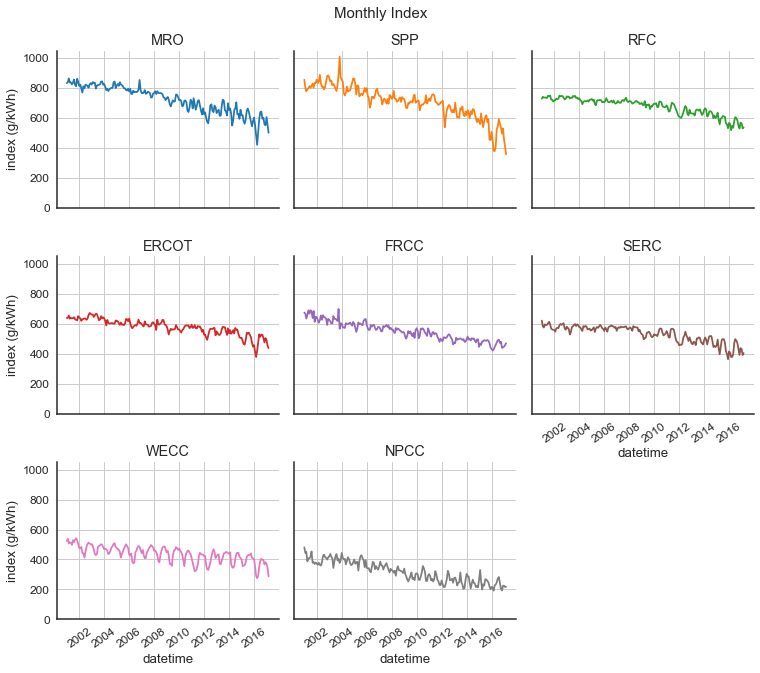

In [20]:
order = ['MRO', 'SPP', 'RFC', 'ERCOT', 'FRCC', 'SERC',
         'WECC', 'NPCC']
FG_kwargs = dict(col='region',
                 hue='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 ylim=(0, 1050))

region_facet_grid(df=gen_index, plot_function=plt.plot, x_axis='datetime',
                  y_axis='index (g/kWh)', col_order=order, 
                  suptitle='Monthly Index', FG_kwargs=FG_kwargs)

#### Viewing all of the lines on a single plot shows that all regions follow the same general trend down

In [46]:
import plotly
import plotly.tools as tls

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode(connected=True)

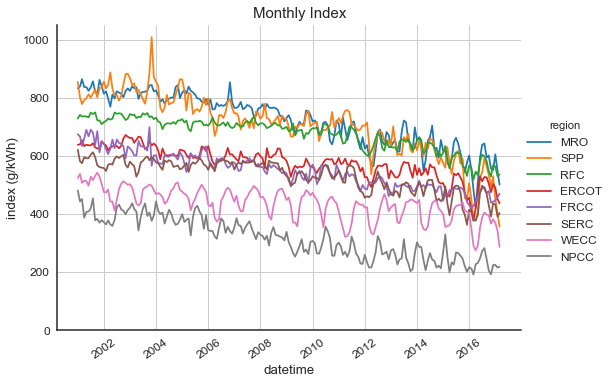

In [42]:
order = ['MRO', 'SPP', 'RFC', 'ERCOT', 'FRCC', 'SERC',
         'WECC', 'NPCC']
FG_kwargs = dict(hue='region',
                 aspect=1.5,
                 size=5,
                 hue_order=order,
                 ylim=(0, 1050))
region_facet_grid(df=gen_index, plot_function=plt.plot, x_axis='datetime',
                  y_axis='index (g/kWh)', add_legend=True, plotly=True,
                  suptitle='Monthly Index', FG_kwargs=FG_kwargs)


An interactive version, in case it's helpful

In [48]:
order = ['MRO', 'SPP', 'RFC', 'ERCOT', 'FRCC', 'SERC',
         'WECC', 'NPCC']

trace = []

for region in order:
    df = gen_index.loc[gen_index['region'] == region]
    trace.append(go.Scatter(x=df['datetime'],
                            y=df['index (g/kWh)'],
                            name=region,
                            mode='lines'))
    

iplot(trace)

## Look at FRCC and SPP

These two regions are well-correlated with the original data, but uncorrelated once they are detrended. I think it's better to detrend because my question is asking if the regions tend to have high/low carbon intensity at the same times of the year. The correlated downward trend doesn't matter for this analysis.

### Without detrending the correlation is 0.84

In [49]:
order = ['FRCC', 'SPP']
trace = []

for region in order:
    df = gen_index.loc[gen_index['region'] == region]
    trace.append(go.Scatter(x=df['datetime'],
                            y=df['index (g/kWh)'],
                            name=region,
                            mode='lines'))

iplot(trace)

### With detrending the correlation is 0.03

In [50]:
order = ['FRCC', 'SPP']
trace = []

for region in order:
    df = gen_index.loc[gen_index['region'] == region]
    trace.append(go.Scatter(x=df['datetime'],
                            y=detrend(df['index (g/kWh)']),
                            name=region,
                            mode='lines'))

iplot(trace)

## Look at ERCOT and SPP

These two regions are well-correlated with the original and detrended data.

### Without detrending the correlation is 0.92

In [51]:
order = ['ERCOT', 'SPP']
trace = []

for region in order:
    df = gen_index.loc[gen_index['region'] == region]
    trace.append(go.Scatter(x=df['datetime'],
                            y=df['index (g/kWh)'],
                            name=region,
                            mode='lines'))

iplot(trace)

### With detrending the correlation is 0.65

In [52]:
order = ['ERCOT', 'SPP']
trace = []

for region in order:
    df = gen_index.loc[gen_index['region'] == region]
    trace.append(go.Scatter(x=df['datetime'],
                            y=detrend(df['index (g/kWh)']),
                            name=region,
                            mode='lines'))

iplot(trace)